In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import plotly
from plotly import graph_objs 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
import nbconvert
import seaborn as sns

from sklearn.model_selection import train_test_split

import string
import nltk
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df= df.drop("Unnamed: 0", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [4]:
df['class'] = df['class'].replace([2], 1)
df['class'] = df['class'].replace([0, 1], [1, 0])
df = df.rename(columns={"class": "target"})

In [5]:
df.head()

,count,hate_speech,offensive_language,neither,target,tweet
0,3,0,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
from sklearn.model_selection import train_test_split
#Train Test Split
x = df.tweet
y = df.target
train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
print(type(train_X))
print(type(train_Y))
print(type(test_X))
print(type(test_Y))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [8]:
train_x = train_X.to_list()
print(type(train_x))

<class 'list'>


In [9]:
test_x = test_X.to_list()
print(type(test_x))

<class 'list'>


In [10]:
train_x[0]

'RT @FunSizedYogi: @TheBlackVoice well how else will white ppl get us to forget our horrific past other than to paint a pretty picture of ho&#8230;'

In [11]:
test_x[0]

'934 8616\ni got a missed call from yo bitch'

In [12]:
train_y_ = train_Y.to_numpy()
train_y = train_y_.reshape((train_y_.shape[0],1))
test_y_ = test_Y.to_numpy()
test_y = test_y_.reshape((test_y_.shape[0],1))

In [13]:
print(f'train_x[1] : {train_x[1]}')
print(f'train_y[1] : {train_y[1]}')

train_x[1] : Funny thing is....it's not just the people doing it. It's the people who seeing these pics and judging the birds. Just as wrong.
train_y[1] : [0]


In [14]:
print(train_y.shape)
print(test_y.shape)

(19826, 1)
(4957, 1)


In [15]:
print(len(train_x))
print(len(test_x))

19826
4957


In [16]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # Note for self- The squeeze is necessary or the list ends up with one element. 
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs


In [17]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


In [18]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks    
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean


In [19]:
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 17139


In [20]:
print(freqs)

{('well', 1): 10, ('els', 1): 3, ('white', 1): 104, ('ppl', 1): 3, ('get', 1): 65, ('us', 1): 15, ('forget', 1): 5, ('horrif', 1): 1, ('past', 1): 2, ('paint', 1): 2, ('pretti', 1): 4, ('pictur', 1): 6, ('ho', 1): 4, ('funni', 0): 97, ('thing', 0): 197, ('...', 0): 1590, ('peopl', 0): 286, ('see', 0): 388, ('pic', 0): 104, ('judg', 0): 19, ('bird', 0): 488, ('wrong', 0): 92, ('nigga', 0): 1461, ('mess', 0): 33, ('bitch', 0): 8864, ('ass', 0): 1151, ('nigggaaa', 0): 1, ('real', 0): 304, ('speak', 0): 43, ('time', 0): 378, ('tryna', 0): 139, ('make', 0): 539, ('look', 0): 602, ('bad', 0): 449, ('like', 0): 2137, ('eat', 0): 296, ('pussi', 0): 1745, ('nah', 0): 104, ('mimi', 0): 10, ('basebal', 0): 13, ('season', 0): 42, ('win', 0): 92, ('yanke', 0): 230, ('love', 0): 592, ('start', 0): 178, ('alway', 0): 208, ('hatin', 0): 15, ('lmao', 0): 293, ('nude', 0): 41, ('call', 0): 456, ('would', 0): 280, ('rather', 0): 50, ('hey', 0): 78, ('girl', 0): 542, ('send', 0): 56, ('tit', 0): 15, ('hoe

In [21]:
#visualization of selected words - just little experimentation
keys = ['fag','white', 'trash', 'black', 'bitch', 'dumb','anyon','suckin', 'sharia', 'meek', 'dicc', 'greedi', 'oklahoma']
data = []

# loop through selected words
for word in keys:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 0) in freqs:
        pos = freqs[(word, 0)]
        
    # retrieve number of negative counts
    if (word, 1) in freqs:
        neg = freqs[(word, 1)]
        
    # append the word counts to the table
    data.append([word, pos, neg])
    
data

[['fag', 139, 87],
 ['white', 210, 104],
 ['trash', 827, 83],
 ['black', 156, 34],
 ['bitch', 8864, 222],
 ['dumb', 186, 11],
 ['anyon', 44, 3],
 ['suckin', 6, 1],
 ['sharia', 1, 0],
 ['meek', 3, 1],
 ['dicc', 4, 0],
 ['greedi', 3, 1],
 ['oklahoma', 1, 1]]

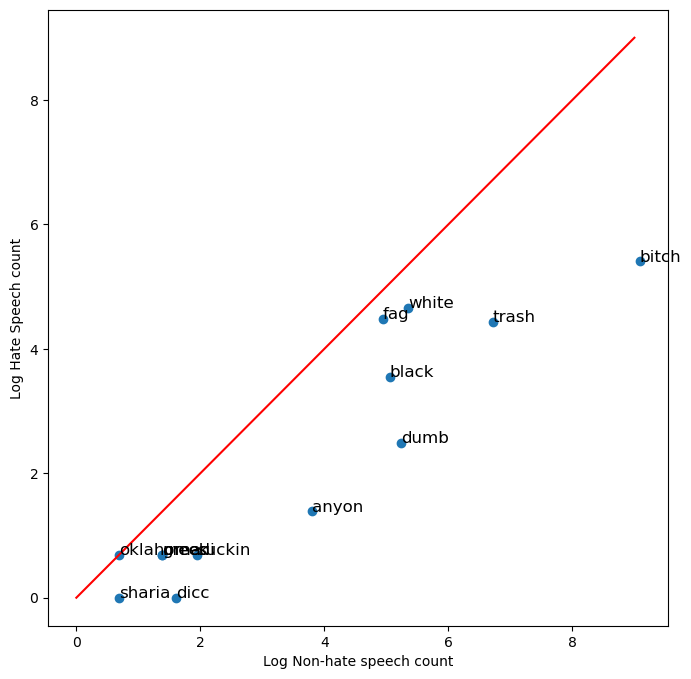

In [22]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Non-hate speech count")
plt.ylabel("Log Hate Speech count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()

In [23]:
print('This is an example of a tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a tweet: 
 RT @FunSizedYogi: @TheBlackVoice well how else will white ppl get us to forget our horrific past other than to paint a pretty picture of ho&#8230;

This is an example of the processed version of the tweet: 
 ['well', 'els', 'white', 'ppl', 'get', 'us', 'forget', 'horrif', 'past', 'paint', 'pretti', 'pictur', 'ho']


In [24]:
#Implementing sigmoid & gradient descent rather than using scikit-learn
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    
    h = 1/(1+np.exp(-z))
    
    
    return h

In [25]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    '''
    # get 'm', the number of rows in matrix x
    m = x.shape[0]
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = 1/(1+np.exp(-z))
        
        # calculate the cost function
        J = -1/m *( np.dot(y.T, np.log(h))+ np.dot((1-y).T , np.log(1-h)))

        # update the weights theta
        theta = theta - (alpha/m * np.dot(x.T, (h-y)))
    
    J = float(J)
    return J, theta

In [26]:
def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(3) 
    
    # bias term is set to 1
    x[0] = 1 
    
    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the hate_speech label 1
        x[1] += freqs.get((word,1),0)
        
        # increment the word count for the not_hate_speech label 0
        x[2] += freqs.get((word,0),0)
     
    
    x = x[None, :]  # adding batch dimension for further processing
    assert(x.shape == (1, 3))
    return x

In [27]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.28440949.
The resulting vector of weights is [-1.9e-07, -1.34e-05, -0.00043659]


In [28]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet,freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x,theta))
    
    
    
    return y_pred

In [29]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    
    
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    test_y = np.squeeze(test_y).tolist()
    y_hat = np.asarray(y_hat)
    accuracy = np.sum(test_y==y_hat)/len(test_y)

    
    
    return accuracy

In [30]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9415


In [34]:
my_tweet = "its melting because you didnt put it in the freezer before you served it you dumb skank! #MKR"
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Hate Speech')
else: 
    print('hate speech')
    

#Need to try with balanced data set

['melt', 'didnt', 'put', 'freezer', 'serv', 'dumb', 'skank', 'mkr']
[[0.45032938]]
hate speech


In [ ]:
df['tweet'][1]

# Balanced Dataset


In [35]:
df1 = pd.read_csv('balanced_data_combined.csv')
df1.head()

,Unnamed: 0,text,class
0,0,Drasko they didn't cook half a bird you idiot ...,1
1,1,Hopefully someone cooks Drasko in the next ep ...,1
2,2,of course you were born in serbia...you're as ...,1
3,3,These girls are the equivalent of the irritati...,1
4,4,RT @YesYoureRacist: At least you're only a tin...,1


In [36]:
df1=df1.drop('Unnamed: 0', axis=1)
df1.shape

(8337, 2)

In [37]:
df1['class'].unique()

array([1, 0])

In [38]:
df1.groupby('class')['class'].agg('count')

class
0    4163
1    4174
Name: class, dtype: int64

In [39]:
df1.shape
df1.dropna(subset=['text'], inplace=True)
df1.shape

(8335, 2)

In [40]:
x = df1.text
y = df1['class']
train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size=0.2, random_state=42)

In [41]:
print(type(train_X))
print(type(test_X))
print(type(train_Y))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [42]:
test_x = test_X.to_list()
train_x = train_X.to_list()

In [43]:
train_Y.shape[0]

6668

In [44]:
train_y = train_Y.to_numpy().reshape((train_Y.shape[0],1))
test_y = test_Y.to_numpy().reshape((test_Y.shape[0],1))
print(train_y.shape)
print(len(train_x))

(6668, 1)
6668


In [45]:
freqs_ = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs_)))
print("len(freqs) = " + str(len(freqs_.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 12522


In [46]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.67596415.
The resulting vector of weights is [-7e-08, 1.407e-05, 0.00011371]


In [47]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy with balanced dataset = {tmp_accuracy:.4f}")

Logistic regression model's accuracy with balanced dataset = 0.4973


In [48]:
##sheesh that's bad